In [7]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [8]:
path = r'C:\Users\mkotyushev\Documents\z\dress'

img1 = cv2.imread(r"C:\Users\mkotyushev\Documents\z\outwear\3046258065_2_5_1.jpg", 0)          # queryImage
img2 = cv2.imread(r"C:\Users\mkotyushev\Documents\z\outwear\3046258065_6_1_1.jpg", 0) # trainImage

Среди детекторов ключевых точек выберем KAZE, как дающий более хорошее качество по сравнению с другими открытыми детекторами  [1]

In [9]:
kaze = cv2.KAZE_create()
kp1, des1 = kaze.detectAndCompute(img1,None)
kp2, des2 = kaze.detectAndCompute(img2,None)

Будем использовать сопоставление с кросс-проверкой, т.е. в сопоставленные добавлять только те точки, которые определяются наиболее подходящими взаимно [2]. Это же автоматически избавляет от ситуации соответствий один-много и много-один

In [10]:
bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(des1,des2)

Отсортируем совпадения в порядке возрастания меры удаленности

In [11]:
matches = sorted(matches, key = lambda x:x.distance)

Получивлшееся количество совпадений:

In [14]:
len(matches)

368

Введем минимальный порог количества совпадений, менее которого будем считать изображения различными:

In [15]:
MIN_MATCH_COUNT = 10

Воспользуемся RANSAC (аббр. RANdom SAmple Consensus) для нахождения наиболее правдоподобного гомографического преобразования  [3]. Его использование в случае сопоставления одежды предпочтительнее, чем прямой перебор и LEAST_MEDIAN, поскольку можно задать допустимое отклонение точек, которое легко может быть из-за гибкости и объемности одежды. 

In [16]:
if len(matches)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(matches),MIN_MATCH_COUNT))
    matchesMask = None

RANSAC возвращает маску подошедшых сопоставлений, по которой их количества мы можем оценить качество совпадения изображений.

In [25]:
np.sum(mask)

21

In [26]:
is_enough = np.sum(mask) > 6
is_enough

True

Для точек в количестве менее пяти всегда найдется преобразование, поэтому пороговое значение должно быть больше. Долю этих точек по отношению  к общему количеству точек каждого из изображений использовать в качестве критерия не стоит, т.к. на это могут вляить области, не относящиеся к самой вещи, а также качество фото. 

Так же RANSAC возвращает матрицу найденного пространственного преобразования:

In [48]:
M

array([[  7.01740572e-01,  -2.52371566e-02,   3.79901683e+01],
       [ -2.44031719e-01,   6.13893266e-01,   2.85469278e+02],
       [ -2.38310120e-04,  -5.33595819e-04,   1.00000000e+00]])

Используем ее, чтобы вычислить масштабные коэффициенты по двум осям [4].

In [18]:
scale_x = np.sqrt(M[0,0]**2+M[1,0]**2)
scale_x

0.74296117677020235

In [19]:
scale_y = np.sqrt(M[0,1]**2+M[1,1]**2)
scale_y

0.61441179690912673

Будем отбраковывать по слишком сильному сжатию или растяжению 

In [20]:
is_not_too_distorted = 0.5 < scale_x/scale_y < 2

In [21]:
is_not_too_distorted

True

и по относительному масштабу как в сторону увеличения, так и в сторону уменьшения. [5]

In [22]:
appropriate_scale = 3

In [23]:
is_not_too_scaled = (1/appropriate_scale < scale_x < appropriate_scale) and (1/appropriate_scale < scale_y < appropriate_scale)

In [24]:
is_not_too_scaled

True

In [ ]:
Наконец, если все условия выполнены, построим изображения с сопоставленными точками и преобразованной границей.

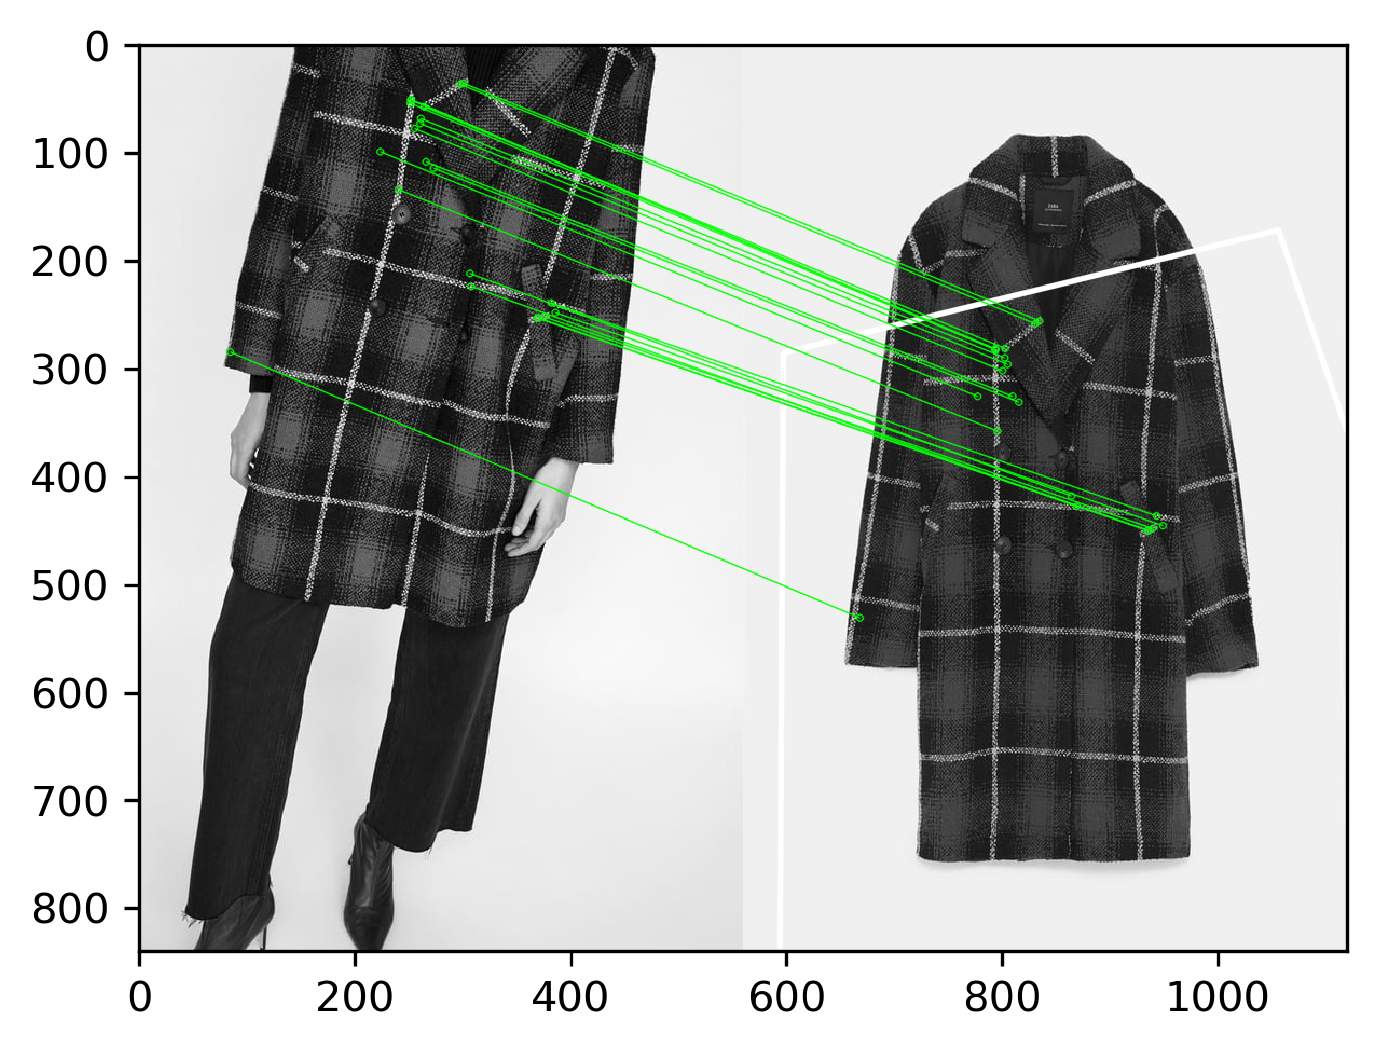

(<matplotlib.image.AxesImage at 0x21d80a1a438>, None)

In [59]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)),plt.show()

__Ссылки__:

[1] https://dspace.spbu.ru/bitstream/11701/3991/1/st010290.pdf

[2] https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html

[3] https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html

[4] https://en.wikipedia.org/wiki/Transformation_matrix

[5] OpenCV Computer visio projects with Python - 2016, Howse J., Joshi P.